# <a style = background:lightgreen;color:black>Settlement Prediction on train_s (preprocessing) </a>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## <a style=background:yellow;color:black id='eda_preproc'> EDA and preprocessing</a>

In [15]:
path_train_s = '../DATA/train_s.csv'

train_s = pd.read_csv(path_train_s)

The first column `Unnamed:0` and the second one (ID) are the same, so we can remove the first one.

In [16]:
del train_s['Unnamed: 0']

`ID` is an unique identifier for each row in the dataset, but it's not from 0 to 106639 (total number of rows).

`Case identifier` is an unique identifier for the cases. <a style=color:deepskyblue> The number before the frontslash indicates when the violation was registered (iscritto a ruolo) (e.g. the second violation of the year 2016 will be registered as 2/2016). BUT, pay attention! You may have more case identifiers repeated because each office of each city has its own register. </a>

In our data the case identifier together with the city (City of the judge’s office) is a primary key.

In [17]:
assert len(train_s)==len(train_s.groupby(['Case identifier', "City of the judge’s office"]).size())

`Date` is the starting date of the case. Notice that each case identifier may have more starting dates (due to the fact that Case identifier is not a primary key in the dataset). 

In [18]:
train_s['Date'] = pd.to_datetime(train_s['Date'])

`Object` is a code which identifies the type of the lawsuit. In our dataset we have two macrotypes of objects (OSA (Opposizioni Sanzioni Amministrative) and OR). The number after OSA or OR represents the specific type of the object.

There are 12 types of lawsuit objects in the dataset.

`Judge Identifier` is an unique identifier given to each Judge. There are 547 judges in the dataset.

`Section` is the judge's tribunal section. There are 27 sections in the dataset. There may be for the same year, same city and the same section, multiple judges. 

In [19]:
train_s['Year'] = train_s['Date'].dt.year
train_s.groupby(['Year','City of the judge’s office', 'Section'])['Judge Identifier'].unique()

Year  City of the judge’s office  Section
1998  Cagliari                    1                                                 [Judge_68]
2005  Cagliari                    1                                       [Judge_75, Judge_77]
      Firenze                     F3                                               [Judge_109]
      L'Aquila                    1                                     [Judge_120, Judge_122]
      Palermo                     1^                                               [Judge_398]
                                                                   ...                        
2021  Roma                        6          [Judge_456, Judge_527, Judge_461, Judge_537, J...
      Torino                      2          [Judge_553, Judge_552, Judge_545, Judge_548, J...
      Trento                      1                                                [Judge_569]
      Trieste                     1               [Judge_571, Judge_573, Judge_570, Judge_572]
      Ve

In [20]:
del train_s['Year'] # We just used Year in order to see how many judges there were per year, city and section

`City of the judge’s office` is the city in which the judge's office is located. There are 20 cities in the dataset. As you can see in the following barplot, the cases are not balanced in the cities.

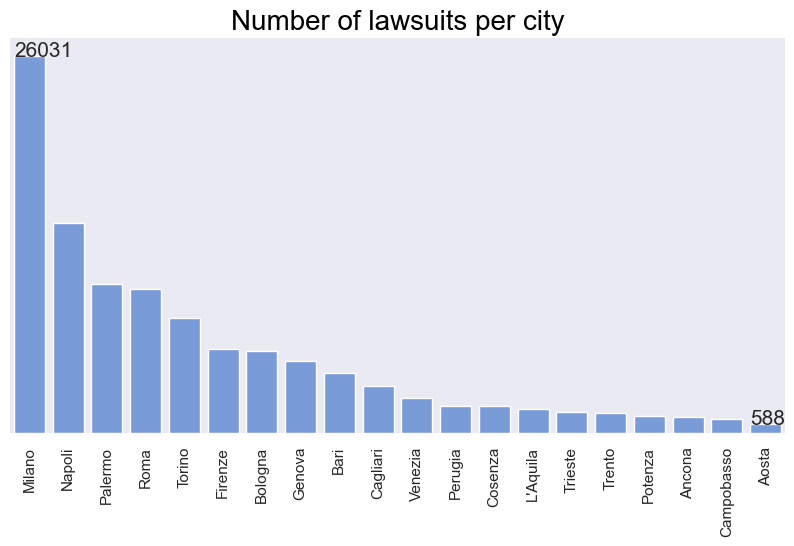

In [21]:
sns.set_theme(rc={"axes.spines.right": False,
                  "axes.spines.top": False,
                  'axes.spines.left': False,
                  'axes.spines.bottom': False})

f, axs = plt.subplots(1, figsize=(10,5))
    
sns.barplot(data = train_s.groupby(['City of the judge’s office'])\
            .size().reset_index().rename(columns={0:'Count'})\
            .sort_values(['Count'], ascending=False),
            x='City of the judge’s office',
            y= 'Count',
            color='cornflowerblue',
            saturation=0.7,
           ax=axs)

bars = list(train_s.groupby(['City of the judge’s office'])\
            .size().reset_index().rename(columns={0:'Count'})\
            .sort_values(['Count'], ascending=False)['City of the judge’s office'])

x_pos = np.arange(len(bars))
plt.xticks(x_pos, bars, rotation=90)
plt.subplots_adjust(bottom=0.2, top=0.99)

heights=np.array(train_s.groupby(['City of the judge’s office'])\
            .size().reset_index().rename(columns={0:'Count'})\
            .sort_values(['Count'], ascending=False)['Count'])

plt.text(x = -0.4 , y = heights[0]+1, s = heights[0], size = 15)
plt.text(x = len(bars)-1.4 , y = heights[-1]+1, s = heights[-1], size = 15)
plt.xlabel('City of the judge’s office', fontsize=12)
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.title('Number of lawsuits per city', fontsize=20, color='black')
plt.show()

`Tax Related` indicates if the case is tax related. It gets either nan or True as values, so we decided to substitute all the NaN with 0. There are 101516 not tax related rows and 5123 tax related rows.

In [22]:
train_s['Tax Related'] = train_s['Tax Related'].replace(np.nan, 0)
train_s['Tax Related'] = train_s['Tax Related'].replace(True, 1)
train_s.groupby(['Tax Related']).size().reset_index().rename(columns={0:'Count'})

,Tax Related,Count
0,0,101516
1,1,5123


`Value` is the monetary value of the lawsuit. Example: I got a traffic ticket for speeding of 500€ and I appel to court (the 500€ of the ticket represents the value of the lawsuit). It is formatted as string, we have to remove the 'Euro' and take just the number, moreover, we have to remove the point which in Italy is used to separate the thousands.

In [23]:
train_s['Value formatted'] = pd.to_numeric(train_s['Value']\
    .str.replace('Euro ', '').str.replace('.','').str.replace(',', '.'), errors='coerce')
    
del train_s['Value']

/var/folders/j3/6zzd1jr16pb3yxx70_376pmw0000gn/T/ipykernel_2758/2797517375.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('Euro ', '').str.replace('.','').str.replace(',', '.'), errors='coerce')


In [10]:
## THIS IS A VERSION OF THE PREVIOUS CELL WRITTEN BY HAND
# taxes_string = np.array(train_s['Value'])

# taxes_string_number = [string[5:] for string in taxes_string]

# taxes_number = []
# for value_string_wrong in taxes_string_number:
#     value_string = ''
#     for chr_ in value_string_wrong:
#         if chr_ != '.' and chr_ != ',':
#             value_string += chr_
#         elif chr_ == ',':
#             value_string += '.'
#     taxes_number.append(float(value_string)) # we need to transform the number in float

# train_s['Value formatted'] = taxes_number
# del train_s['Value']

`Unified contribution` is the monetary cost for starting the lawsuit. Basically, to start a lawsuit there is the need of a "budget" that is the unified contribution.
The unified contribution depends from the value of the lawsuit. The following are the unified contribution tables (of the first lawsuit grade) valid since the 25/06/2014 (first one) and before (second one).

<a style=color:deepskyblue>$$SINCE - 25/06/2014 (First Grade)$$ </a>
<table>
    <tr> <td> Lawsuit value</td> <td> Unified contribution</td> </tr>
    <tr> <td> 0€</td> <td>43€, 237€ and 98€ </td> </tr>
    <tr> <td> 1€-1000€</td> <td> 43€</td> </tr>
    <tr> <td> 1000.01€-1100€</td> <td> 43€</td> </tr>
    <tr> <td> 1100.01€-5200€ </td> <td> 98€</td> </tr>
    <tr> <td> 5200.01€-26000€</td> <td> 237€</td> </tr>
    <tr> <td> 26000.01€-52000€</td> <td> 518€</td> </tr>
    <tr> <td> 52000.01€-260000€</td> <td> 759€</td> </tr>
    <tr> <td> 260000.01€-520000€</td> <td> 1214€</td> </tr>
    <tr> <td> 520000.01€-∞</td> <td> 1686€</td> </tr>
</table>

<a style=color:deepskyblue> $$BEFORE - 25/06/2014 (First Grade)$$</a> 
<table>
    <tr> <td> Lawsuit value</td> <td> Unified contribution</td> </tr>
    <tr> <td> 0€</td> <td>37€, 85€, 206€ and 450€</td> </tr>
    <tr> <td> 1€-1000€</td> <td>37€ </td> </tr>
    <tr> <td> 1000.01€-1100€</td> <td>37€ </td> </tr>
    <tr> <td> 1100.01€-5200€ </td> <td>85€ </td> </tr>
    <tr> <td> 5200.01€-26000€</td> <td>206€ </td> </tr>
    <tr> <td> 26000.01€-52000€</td> <td>450€ </td> </tr>
    <tr> <td> 52000.01€-260000€</td> <td>660€ </td> </tr>
    <tr> <td> 260000.01€-520000€</td> <td>1056€ </td> </tr>
    <tr> <td> 520000.01€-∞</td> <td> 1466€</td> </tr>
</table>

In this field there are 6461 NaN values.

Moreover, this field is formatted as the Value column was formatted, so we have to remove 'Euro' and convert the field as float. Its name will be `Unified Contribution formatted`. Once you have done it, you can see that the minimum unified contribution is 1 euro and the maximum is 98147.

In [25]:
train_s['Unified Contribution formatted'] = pd.to_numeric(train_s['Unified Contribution']\
    .str.replace('Euro ', '').str.replace('.','').str.replace(',', '.'), errors='coerce')
    
del train_s['Unified Contribution']

/var/folders/j3/6zzd1jr16pb3yxx70_376pmw0000gn/T/ipykernel_2758/486384596.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('Euro ', '').str.replace('.','').str.replace(',', '.'), errors='coerce')


In [61]:
# # THIS IS A VERSION OF THE PREVIOUS CELL WRITTEN BY HAND

# un_contr_string = train_s['Unified Contribution']

# un_contr_string_number =[]
# for string in un_contr_string:
#     if pd.isna(string)==False:
#         un_contr_string_number.append(string[5:])
#     else:
#         un_contr_string_number.append(pd.NA)

# un_contr_number = []
# for value_string_wrong in un_contr_string_number:
#     value_string = ''
#     if pd.isna(value_string_wrong)==False:
#         for chr_ in value_string_wrong:
#             if chr_ != '.' and chr_ != ',':
#                 value_string += chr_
#             elif chr_ == ',':
#                 value_string += '.'
#         un_contr_number.append(float(value_string)) # we need to transform the number in float
#     else:
#         un_contr_number.append(pd.NA)

# train_s['Unified Contribution formatted'] = un_contr_number
# del train_s['Unified Contribution']


 In the following chunks we create a function which returns the indexes of the rows which are probably anomalies. To do this we check in each row the value of Value formatted. If the value formatted is in a given range, then its Unified Contribution formatted must be in a given range to be a correct value (the tables are shown above: there are two of them because after the 25th June 2014 they changed). If the Unified Contribution is not in that range, then the function append the index in the anomalies_index list. Notice the following things:  

* The NaN are not considered because otherwise pd.NA in [1,2,3] returns an error. We will analyze them separetely.
* We are considering two tables because after the 25th June 2014 they changed.
* We are considering the Value formatted transformed in integers because the values with float are far from the boundaries and so there is no danger that a row ends up in another range when we consider it as int.
* We create also a function (unified_contribution_calculator) which gets the array of the "standard" values of the unified contribution like the ones you've seen in the previous table and returns an array with these values, these values multipled by 0.5, these values multipied by 1.5 and these values multiplied by 2. We did this in order to eliminate just the obvious anomalies.


In [26]:
def retrieve_oddness(data, range_table):
        '''
        This function iterates through each row of the data and through each row in range_table and
        if the Value formatted of a row in the data is in a range of the Lawsuit Value, then it is checked also if 
        the Unified Contribution of that row is in the right Unified Contribution range.
        '''
        anomalies_index = []
        
        for row_index_data in range(len(data)):
            for row_index_table in range(len(range_table)):
                if int(data.iloc[row_index_data]['Value formatted']) in range_table.iloc[row_index_table]['Lawsuit Value']:
                    if data.iloc[row_index_data]['Unified Contribution formatted'] not in range_table.iloc[row_index_table]['Unified Contribution']:
                        anomalies_index.append(row_index_data)
                    break # once we find the right row (value-unified contribution) we don't need to check the ones below
                        
        return anomalies_index

In [27]:
def unified_contribution_calculator(in_array):
    out_array = list(in_array*0.5)+list(in_array*1)+list(in_array*1.5)+list(in_array*2)
    return np.sort(np.array(out_array))

The unified_contribution_calculator will be fed with the values of the first grade and the values of the second grade (which are the values of the first grade multiplied by 1.5).

In [28]:
table_range_since_25_06_2014 = pd.DataFrame({
    'Lawsuit Value': [[0],np.arange(1,1101),np.arange(1101,5201),np.arange(5201,26001),np.arange(26001,52001),np.arange(52001,260001),np.arange(260001,520001),np.arange(520001, 3500000)],
    'Unified Contribution' : [unified_contribution_calculator(np.array([43,98,237,259,518,43*1.5,98*1.5,237*1.5,259*1.5,518*1.5])),
                              unified_contribution_calculator(np.array([43,43*1.5])),
                              unified_contribution_calculator(np.array([98,98*1.5])),
                              unified_contribution_calculator(np.array([237,237*1.5])),
                              unified_contribution_calculator(np.array([518,518*1.5])),
                              unified_contribution_calculator(np.array([759,759*1.5])),
                              unified_contribution_calculator(np.array([1214,1214*1.5])),
                              unified_contribution_calculator(np.array([1686,1686*1.5]))]
})

table_range_before_25_06_2014 = pd.DataFrame({
    'Lawsuit Value': [[0],np.arange(1,1101),np.arange(1101,5201),np.arange(5201,26001),np.arange(26001,52001),np.arange(52001,260001),np.arange(260001,520001),np.arange(520001,3500000)],
    'Unified Contribution' : [unified_contribution_calculator(np.array([37,85,206,450,37*1.5,85*1.5,206*1.5,450*1.5])),
                              unified_contribution_calculator(np.array([37,37*1.5])),
                              unified_contribution_calculator(np.array([85,85*1.5])),
                              unified_contribution_calculator(np.array([206,206*1.5])),
                              unified_contribution_calculator(np.array([450,450*1.5])),
                              unified_contribution_calculator(np.array([660,660*1.5])),
                              unified_contribution_calculator(np.array([1056,1056*1.5])),
                              unified_contribution_calculator(np.array([1466,1466*1.5]))]
})

train_s_since_25_06_2014_complete = train_s.loc[train_s['Date']>='2014-06-25'][['ID','Value formatted', 'Unified Contribution formatted']]
train_s_since_25_06_2014_not_NA = train_s_since_25_06_2014_complete.dropna()  
train_s_before_25_06_2014_complete = train_s.loc[train_s['Date']<'2014-06-25'][['ID','Value formatted', 'Unified Contribution formatted']]
train_s_before_25_06_2014_not_NA = train_s_before_25_06_2014_complete.dropna() 

In [29]:
anomalies_index_since_25_06_2014 = retrieve_oddness(train_s_since_25_06_2014_not_NA, table_range_since_25_06_2014)

anomalies_ID_since_25_06_2014 = []

for idx in anomalies_index_since_25_06_2014:
    anomalies_ID_since_25_06_2014.append(train_s_since_25_06_2014_not_NA.iloc[idx]['ID'])

anomalies_index_before_25_06_2014 = retrieve_oddness(train_s_before_25_06_2014_not_NA, table_range_before_25_06_2014)

anomalies_ID_before_25_06_2014 = []

for idx in anomalies_index_before_25_06_2014:
    anomalies_ID_before_25_06_2014.append(train_s_before_25_06_2014_not_NA.iloc[idx]['ID'])

df_anomaly_since_25_06_2014 = train_s.loc[train_s['ID'].isin(anomalies_ID_since_25_06_2014)]

df_anomaly_before_25_06_2014 = train_s.loc[train_s['ID'].isin(anomalies_ID_before_25_06_2014)]

<a style=color:deepskyblue> After analyzing the anomalies obtained with these function, we have decided to remove them from the data. This because they are just 2054+1492 rows (3.33% of train_s) and so it's not worth trying to substitute wrong values with the ones which respect the unified contribution boundaries. Also, we have decided to remove the NA values because we couldn't find a reason why there is no value in there. The only pattern that we found is that in the dataset with ONLY the "Unified Contribution formatted"'s NaNs, the Lawsuits with 0 number of persons are 71%, whereas in the dataset without anomaly they are just the 12%.</a>

In [30]:
anomaly_IDs = list(df_anomaly_since_25_06_2014['ID'])+list(df_anomaly_before_25_06_2014['ID'])

train_s_no_anomaly = train_s.loc[~train_s['ID'].isin(anomaly_IDs)]

In [31]:
train_s_no_anomaly_NA = train_s_no_anomaly.loc[train_s_no_anomaly['Unified Contribution formatted'].isna()]
to_remove_anomalies = list(df_anomaly_before_25_06_2014['ID'])+list(df_anomaly_since_25_06_2014['ID'])
to_remove_NA = list(train_s_no_anomaly_NA['ID'])
train_s_cleaned = train_s.loc[~train_s['ID'].isin(to_remove_anomalies)]
train_s_cleaned = train_s_cleaned.loc[~train_s_cleaned['ID'].isin(to_remove_NA)]
# train_s_cleaned.to_excel('../DATA/train_s_cleaned.xlsx')

We also find out that in the dataset with only NaN there is preponderance of number of persons equal to 0. This can be interesting in order to understand why there are NaNs in the Unified Contribution formatted column (because in the dataset with no NaN number of persons equal to 0 is the minorance).

In [32]:
train_s_no_anomaly_NA_count = train_s_no_anomaly_NA.groupby(['Number of Persons'])\
        .size().reset_index().rename(columns={0:'Count'})\
        .sort_values(['Count'], ascending=False)

train_s_no_anomaly_count = train_s_no_anomaly.loc[~train_s_no_anomaly['Unified Contribution formatted'].isna()].groupby(['Number of Persons'])\
        .size().reset_index().rename(columns={0:'Count'})\
        .sort_values(['Count'], ascending=False)

train_s_no_anomaly_NA_count['Count %'] = train_s_no_anomaly_NA_count['Count'].transform(lambda x: x/x.sum())
train_s_no_anomaly_count['Count %'] = train_s_no_anomaly_count['Count'].transform(lambda x: x/x.sum())

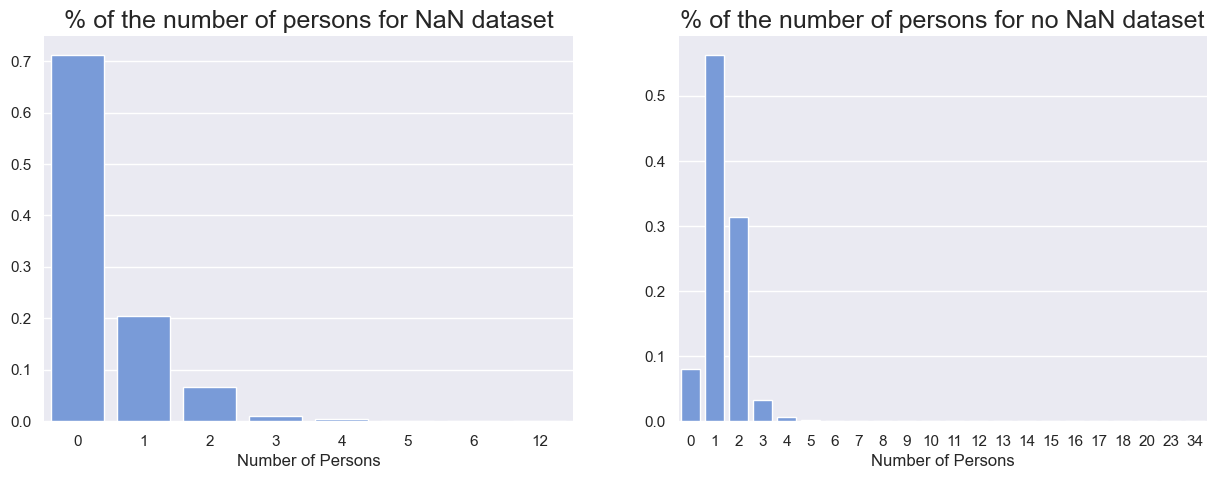

In [33]:
sns.set_theme(rc={"axes.spines.right": False,
                  "axes.spines.top": False,
                  'axes.spines.left': False,
                  'axes.spines.bottom': False})

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
sns.barplot(data =train_s_no_anomaly_NA_count,
            x='Number of Persons',
            y= 'Count %',
            color='cornflowerblue',
            saturation=0.7,
           ax=axs[0])

sns.barplot(data =train_s_no_anomaly_count,
            x='Number of Persons',
            y= 'Count %',
            color='cornflowerblue',
            saturation=0.7,
           ax=axs[1])

axs[0].set(ylabel='')
axs[0].set_title('% of the number of persons for NaN dataset', fontsize=18)
axs[1].set(ylabel='')
axs[1].set_title('% of the number of persons for no NaN dataset', fontsize=18)
plt.show()

<a style=color:deepskyblue> From now we are going to use the train_s_cleaned dataset. </a>

`Primary Actor` is the accusing part. There are 14248 NaN values. It is meaningless to check how many are the unique values because they are encripted for privacy reasons.

`Secondary Actor` is always the accusing part. There are 98547 NaN values.

`Primary Defendant` is the defendant of the lawsuit. There are 14287 NaN values.

`Secondary Defendant` is the defendant of the lawsuit. There are 77331 NaN values.

<a style=color:deepskyblue> The following is an interesting pattern. There are almost the same number of NaN in the columns Primary Actor and Primary Defendant and almost all of them are in common (there are 13253 NaN values in Primary Defendant and in common with Primary Actor there are 13115 of them)  </a>

In [34]:
pr_actor = np.array(train_s_cleaned['Primary Actor'])
pr_def = np.array(train_s_cleaned['Primary Defendant'])

counter=0
for i in np.argwhere(pd.isna(pr_actor)):
    if pd.isna(pr_actor[i]) and pd.isna(pr_def[i]):
        counter+=1
        
counter

13115

`Number of Lawyers`: lawyers of the actor + lawyers of the defendant

`Number of Legal Parties`:  the number of legal parties involved in the lawsuit

`Number of Persons`: number of attacked people .

`Settlement`: How much the lawyers earn from the lawsuit.

The settlement usually is a percentage of the value of the lawsuit, but it all depends from the agreements: <a style=color:deepskyblue>if my lawyer and I stipulate a contract such that at the end of the lawsuit the lawyer has to be paid 1000 euro end eventually we win, even if the judge determines that the lawyer of the winner has to be paid 500 euro (and so the loser has to repay the winner just of these 500 euro) the winner lawyer has to be paid 1000 euro and so I (the winner) have to pay the remaining 500 euro. </a>

In [35]:
train_s_cleaned['Settlement_greater_Value']=(train_s_cleaned['Value formatted']!=0)&(train_s_cleaned['Settlement']>train_s_cleaned['Value formatted'])
train_s_cleaned['Settlement_2*greater_Value']=(train_s_cleaned['Value formatted']!=0)&(train_s_cleaned['Settlement']>2*train_s_cleaned['Value formatted'])

In [36]:
train_s_cleaned.groupby(['Settlement_greater_Value','Settlement_2*greater_Value'])\
            .size().reset_index().rename(columns={0:'Count'})\
            .sort_values(['Count'], ascending=False)

,Settlement_greater_Value,Settlement_2*greater_Value,Count
0,False,False,92305
1,True,False,3715
2,True,True,612


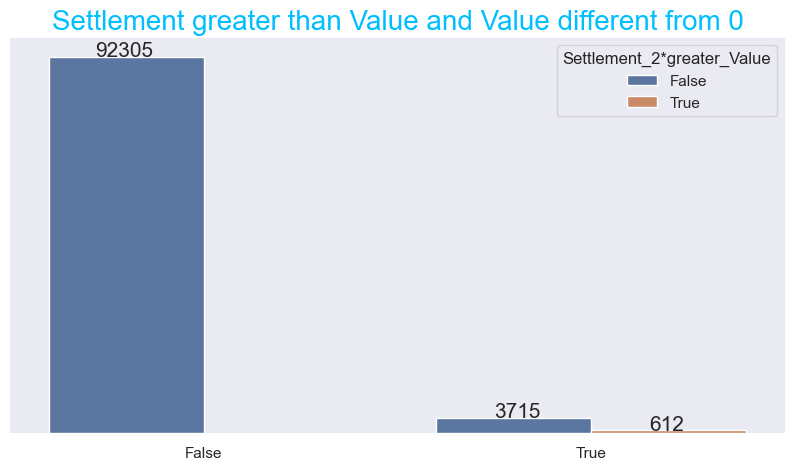

In [37]:
sns.set_theme(rc={"axes.spines.right": False,
                  "axes.spines.top": False,
                  'axes.spines.left': False,
                  'axes.spines.bottom': False})

f, axs = plt.subplots(1, figsize=(10,5))
    
sns.barplot(data = train_s_cleaned.groupby(['Settlement_greater_Value','Settlement_2*greater_Value'])\
            .size().reset_index().rename(columns={0:'Count'})\
            .sort_values(['Count'], ascending=False),
            x='Settlement_greater_Value',
            y= 'Count',
            hue='Settlement_2*greater_Value',
            #color='cornflowerblue',
            saturation=0.7,
           ax=axs)

bars = list(train_s_cleaned.groupby(['Settlement_greater_Value','Settlement_2*greater_Value'])\
            .size().reset_index().rename(columns={0:'Count'})\
            .sort_values(['Count'], ascending=False)['Settlement_greater_Value'])

x_pos = np.arange(len(bars)-1)
plt.xticks(x_pos, bars[:2])
plt.subplots_adjust(bottom=0.2, top=0.99)

heights=np.array(train_s_cleaned.groupby(['Settlement_greater_Value','Settlement_2*greater_Value'])\
            .size().reset_index().rename(columns={0:'Count'})\
            .sort_values(['Count'], ascending=False)['Count'])

plt.text(x = -0.28 , y = heights[0]+1, s = heights[0], size = 15)
plt.text(x = len(bars)-2.25 , y = heights[1], s = heights[1], size = 15)
plt.text(x = len(bars)-1.85, y = heights[2], s = heights[2], size = 15)
plt.title('Settlement greater than Value and Value different from 0', fontsize=20,
          color='deepskyblue')
plt.yticks([])
plt.ylabel('')
plt.xlabel('')
plt.show()

Let's analyze the spearman (not linear) correlation between the numerical columns of the dataset. We can see that there are some columns which are highly correlated. For example, the number of persons is highly correlated with the number of legal parties. The settlement is highly correlated with the value of the lawsuit.

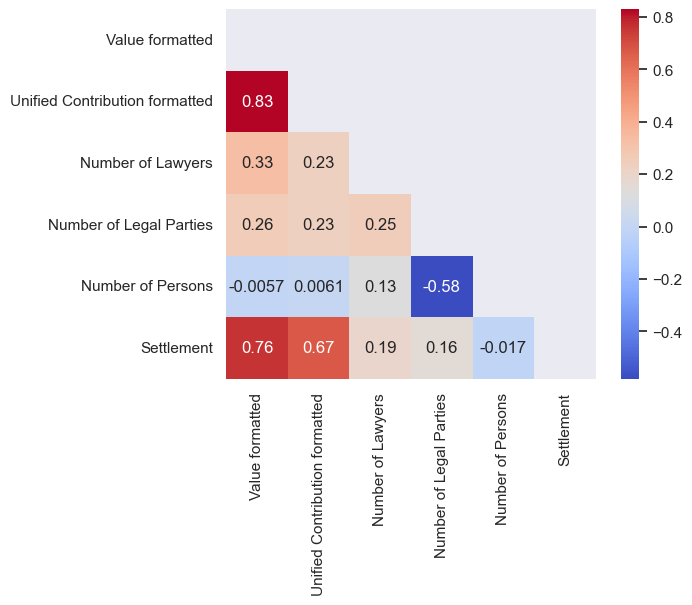

In [38]:
df_num = train_s_cleaned[['Value formatted', 'Unified Contribution formatted',
 'Number of Lawyers', 'Number of Legal Parties', 'Number of Persons', 'Settlement']]

corr = df_num.corr('spearman')

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, cmap=plt.cm.coolwarm, annot=True,mask=mask, square=True)
plt.show()

<a style=color:deepskyblue> **The last preprocessing steps (we want to delete some potential anomalies such as the ones whose settlement is greater than 1'000'000 or a lot higher than the corresponding value):** </a>

* Remove the Settlment values that are close to the corresponding Value formatted multiplied by 10, 100, 1'000, 10'000 and in the range 10'000 < Settlement < 1'000'000.

* Remove the Settlement value greater than 1'000'000.

* Remove non necessary columns.

* Finally, create the final dataset.

In [39]:
start = 0.9
end = 1.1

first_range = np.arange(start*10,int(end*10+1))
second_range = np.arange(start*100, int(end*100+1))
third_range = np.arange(start*1000, int(end*1000+1))
fourth_range = np.arange(start*10000, int(end*10000+1))

In [40]:
df = train_s_cleaned.loc[(train_s_cleaned['Settlement']<1000000) & (train_s_cleaned['Settlement']>10000)]

IDs_to_remove = []

for i in range(len(df)):
    if df.iloc[i]['Value formatted']!=0:
        ratio = int(df.iloc[i]['Settlement']/df.iloc[i]['Value formatted'])
        if (ratio in first_range) or (ratio in second_range) or (ratio in third_range) or (ratio in fourth_range):
            IDs_to_remove.append(df.iloc[i]['ID'])

In [41]:
for i in range(len(train_s_cleaned)):
    if train_s_cleaned.iloc[i]['Settlement']>=1000000:
        IDs_to_remove.append(train_s_cleaned.iloc[i]['ID'])

In [42]:
final_df = train_s_cleaned.loc[(~train_s_cleaned['ID'].isin(IDs_to_remove))]\
.sort_values(['Settlement'], ascending=False)

In [43]:
IDs_to_remove = list(final_df.loc[(final_df['Settlement']>90000) &
             (final_df['Settlement']>final_df['Value formatted']*5)].ID)

In [44]:
final_df = final_df.loc[~final_df['ID'].isin(IDs_to_remove)]

In [45]:
del final_df['ID']
del final_df['Primary Actor']
del final_df['Secondary Actor']
del final_df['Primary Defendant']
del final_df['Secondary Defendant']
del final_df['Settlement_greater_Value']
del final_df['Settlement_2*greater_Value']

In [72]:
# final_df.to_csv('../DATA/final_train_s.csv')

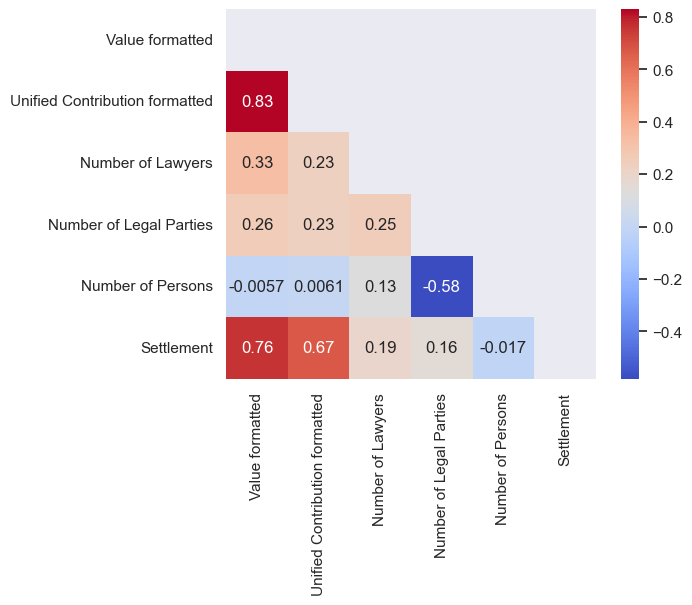

In [46]:
df_num = final_df[['Value formatted', 'Unified Contribution formatted',
 'Number of Lawyers', 'Number of Legal Parties', 'Number of Persons', 'Settlement']]

corr = df_num.corr('spearman')

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, cmap=plt.cm.coolwarm, annot=True,mask=mask, square=True)
plt.show()

## <a style=background:yellow;color:black > Let's convert the variable 'City of the judge’s office' in One-Hot encoding </a>

In [1]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('../DATA/final_train_s.csv')

city_encoder = OneHotEncoder().fit(data[['City of the judge’s office']])

data = pd.concat([data,
  pd.DataFrame(city_encoder.transform(data[['City of the judge’s office']]).toarray(),columns=city_encoder.categories_)],
  axis=1).drop(['City of the judge’s office'],axis=1)

In [ ]:
# # THIS IS A VERSION OF THE PREVIOUS CELL WRITTEN BY HAND

# data = pd.read_csv('../DATA/final_train_s.csv')

# cities = []
# for city in data['City of the judge’s office'].tolist() :

#     if city not in cities : 
#         cities.append(city)

# for city in cities : 
#     data[city] = np.zeros(len(data))

# for i in range(len(data)) : 
#     data[data['City of the judge’s office'].iloc[i]].iloc[i] = 1

# del data['City of the judge’s office']

In [3]:
object_encoder = OneHotEncoder().fit(data[['Object']])

data = pd.concat([data,
  pd.DataFrame(object_encoder.transform(data[['Object']]).toarray(),columns=object_encoder.categories_)],
  axis=1).drop(['Object'],axis=1)

In [ ]:
# # THIS IS A VERSION OF THE PREVIOUS CELL WRITTEN BY HAND

# crimes=[]
# for crime in data['Object'].tolist() :

#     if crime not in crimes : 

#         crimes.append(crime)

# for crime in crimes : 

#     data[crime] = np.zeros(len(data))

# for i in range(len(data)) : 

#     data[data['Object'].iloc[i]].iloc[i] = 1

# del data['Object']

In [51]:
# data.to_csv('final_train_s_dummies.csv')